In [1]:
import numpy as np
import pandas as pd
import os
import random
import cv2
import re
import json
import matplotlib.pyplot as plt

random.seed(42)

In [2]:
def circle_mask(size=(224, 224), border=10, fix=(0,0)):
    mask = np.zeros((size[0], size[1]), dtype=np.uint8) 
    m_center = (size[0] // 2, size[1] // 2)
    m_radius = min(size[0], size[1]) // 2 - border
    mask = cv2.circle(mask, m_center, m_radius, 1, thickness=-1)
    mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
    return mask


def inv_foreground(ref_frame, diff, offset=0.0):
        
        mask = circle_mask()
        
        ref_frame = np.float32(ref_frame)
        diff = np.float32(diff)
        diff = (diff*2 - 255) 
        frame = ref_frame + diff
        
        frame = (frame).astype(np.uint8)
        frame = frame*mask

        return frame
    
def foreground(frame, ref_frame, offset=0.0):
        mask = circle_mask()
        
        frame = np.float32(frame)
        ref_frame = np.float32(ref_frame)

        diff_frame = frame - ref_frame
        diff_frame = diff_frame  + 255
        
        diff_frame = (diff_frame/2).astype(np.uint8)
        diff_frame = diff_frame*mask
        return diff_frame

In [3]:
def display_images(images, titles):
    plt.figure(figsize=(15, 5))  # Adjust the figure size as needed

    for i, (image, title) in enumerate(zip(images, titles), 1):
        plt.subplot(1, 4, i)
        plt.imshow(image)
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [4]:
json_path_real = './datasets/data_Allsight/json_data/real_train_8_transformed.json'
json_path_sim = './datasets/data_Allsight/json_data/sim_train_8_transformed.json'
json_rgb = './datasets/data_Allsight/json_data/old_2_rrrgggbbb/real_test_4_transformed.json'

copy_to_path = '/home/roblab20/dev/allsight/allsight_sim2real/datasets/data_Allsight/diff_images/exp'

# Create the directory if it doesn't exist
if not os.path.exists(copy_to_path):
    os.makedirs(copy_to_path)

df_rgb = pd.read_json(json_rgb).transpose()
df_rgb['diff_frame'] = df_rgb['frame']
old_path = "/home/osher/catkin_ws/src/allsight/dataset/"
new_path = f"./datasets/data_Allsight/all_data/allsight_dataset/"
df_rgb['ref_frame'] = df_rgb['ref_frame'].str.replace(old_path, new_path)

df_real = pd.read_json(json_path_real).transpose()
df_real['diff_frame'] = df_real['frame']

df_sim = pd.read_json(json_path_sim).transpose()
df_sim['diff_frame'] = df_sim['frame']

In [6]:
idx = 4
frame = cv2.resize((cv2.imread(df_real['frame'][idx])), (224,224))
ref_frame = cv2.resize(cv2.imread(df_real['ref_frame'][idx]), (224,224)).astype(np.uint8)

diff_frame = foreground(frame, ref_frame, offset=0.0)
save_path = os.path.join(copy_to_path, f'diff_real_{idx}.jpg')

cv2.imwrite(save_path, diff_frame)
df_real['diff_frame'][idx] = save_path
composed_frame = inv_foreground(ref_frame, diff_frame, offset=0)

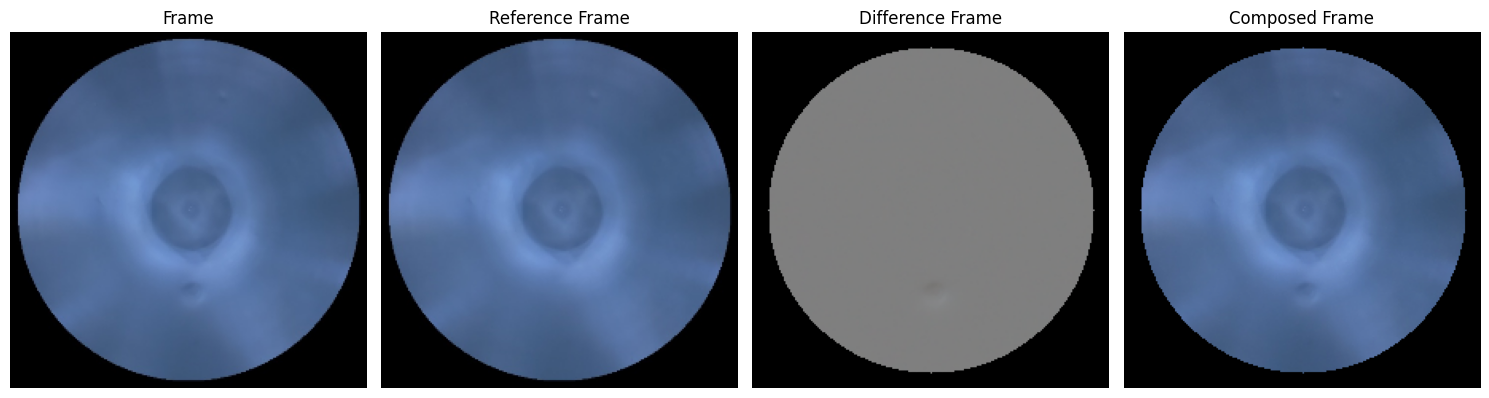

In [7]:
# Display the images using the function
images = [cv2.cvtColor(frame, cv2.COLOR_BGR2RGB),
          cv2.cvtColor(ref_frame, cv2.COLOR_BGR2RGB),
          cv2.cvtColor(diff_frame, cv2.COLOR_BGR2RGB),
          cv2.cvtColor(composed_frame, cv2.COLOR_BGR2RGB)]
titles = ['Frame', 'Reference Frame', 'Difference Frame', 'Composed Frame']

display_images(images, titles)

In [8]:
new_ref_frame = cv2.resize((cv2.imread(df_rgb['ref_frame'][15])), (224,224)).astype(np.uint8)

composed_frame = inv_foreground(new_ref_frame, diff_frame, offset=0)

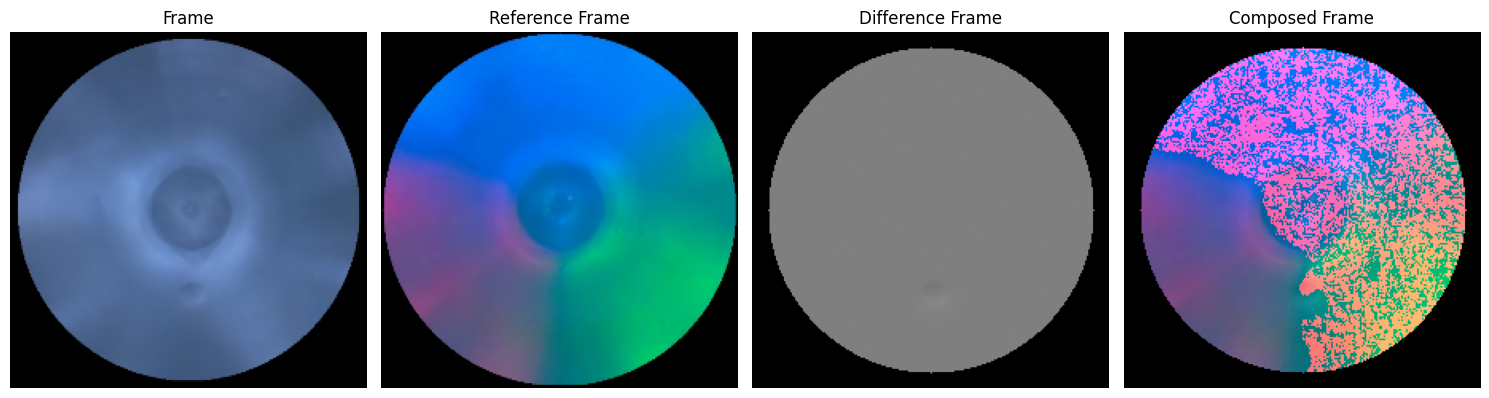

In [10]:
# Display the images using the function
images = [cv2.cvtColor(frame, cv2.COLOR_BGR2RGB),
          cv2.cvtColor(new_ref_frame, cv2.COLOR_BGR2RGB),
          cv2.cvtColor(diff_frame, cv2.COLOR_BGR2RGB),
          cv2.cvtColor(composed_frame, cv2.COLOR_BGR2RGB)]
titles = ['Frame', 'Reference Frame', 'Difference Frame', 'Composed Frame']

display_images(images, titles)


In [ ]:
idx = 15
frame = (cv2.imread(df_sim['frame'][idx])).astype(np.uint8)
ref_frame = (cv2.imread(df_sim['ref_frame'][idx])).astype(np.uint8)

diff_frame = foreground(frame, ref_frame, offset=0.2)
save_path = os.path.join(copy_to_path, f'diff_sim_{idx}.jpg')

cv2.imwrite(save_path, diff_frame)
df_sim['diff_frame'][idx] = save_path

In [ ]:
ref_frame = (cv2.imread(df_sim['ref_frame'][15])).astype(np.uint8)

composed_frame = inv_foreground(ref_frame, diff_frame, offset=0.2)

In [ ]:
mask = circle_mask()
frame[mask==0] = 0
ref_frame[mask==0] = 0
diff_frame[mask==0] = 0
composed_frame[mask==0] = 0
# Display the images using the function
images = [cv2.cvtColor(frame, cv2.COLOR_BGR2RGB),
          cv2.cvtColor(ref_frame, cv2.COLOR_BGR2RGB),
          cv2.cvtColor(diff_frame, cv2.COLOR_BGR2RGB),
          cv2.cvtColor(composed_frame, cv2.COLOR_BGR2RGB)]
titles = ['Frame', 'Reference Frame', 'Difference Frame', 'Composed Frame']

display_images(images, titles)

In [ ]:
for idx in range(100):
    frame = (cv2.imread(df_real['frame'][idx])).astype(np.uint8)
    ref_frame = (cv2.imread(df_real['ref_frame'][idx])).astype(np.uint8)
    
    diff_image = foreground(frame, ref_frame, offset=0.2)
    save_path = os.path.join(copy_to_path, f'diff_real_{idx}.jpg')
    
    cv2.imwrite(save_path, diff_image)
    df_real['diff_frame'][idx] = save_path
    
for idx in range(100):
    frame = (cv2.imread(df_sim['frame'][idx])).astype(np.uint8)
    ref_frame = (cv2.imread(df_sim['ref_frame'][idx])).astype(np.uint8)
    
    diff_image = foreground(frame, ref_frame, offset=0.2)
    save_path = os.path.join(copy_to_path, f'diff_sim_{idx}.jpg')
    
    cv2.imwrite(save_path, diff_image)
    df_sim['diff_frame'][idx] = save_path

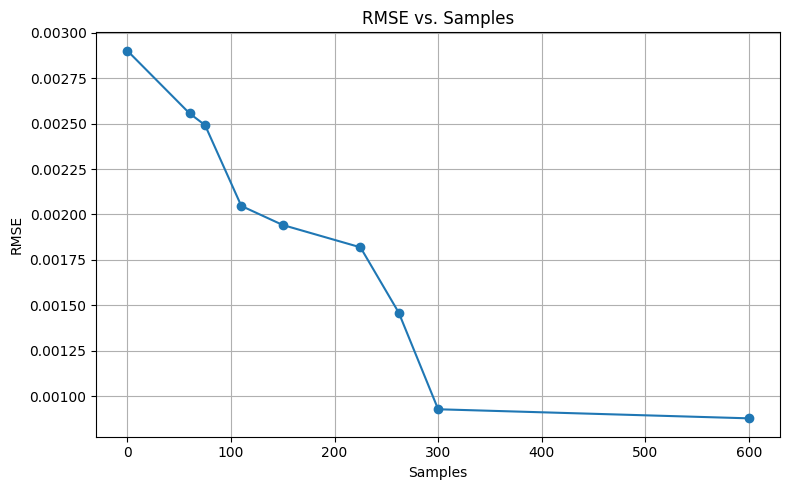

In [2]:
# graph fine tune
import matplotlib.pyplot as plt

# Sample data
samples = [0, 60, 75, 110, 150, 225, 262, 300, 600]
rmse = [0.002902, 0.002557, 0.002492, 0.002047, 0.001942, 0.001819, 0.001459, 0.000927, 0.000877]

# Create the graph
plt.figure(figsize=(8, 5))
plt.plot(samples, rmse, marker='o', linestyle='-')
plt.title('RMSE vs. Samples')
plt.xlabel('Samples')
plt.ylabel('RMSE')
plt.grid(True)
plt.tight_layout()

# Show the graph
plt.show()